# Optic Flow

## RAFT library 
https://github.com/princeton-vl/RAFT


### view optic flow frames

In [1]:
import sys
sys.path.append('core')

import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

from argparse import Namespace
from utils import flow_viz
from utils import frame_utils

DEVICE = 'cuda'

In [4]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    import matplotlib.pyplot as plt
    plt.imshow(img_flo / 255.0)
    #plt.imshow(flo)
    plt.axis('off')  
    plt.show()
    

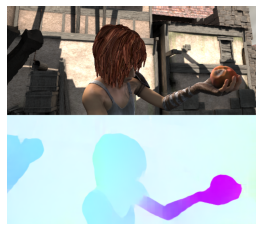

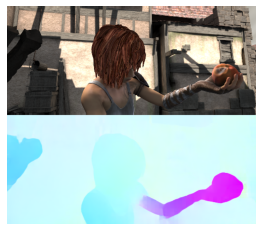

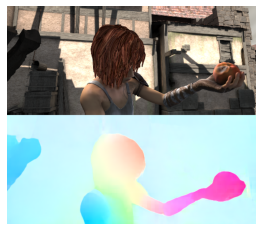

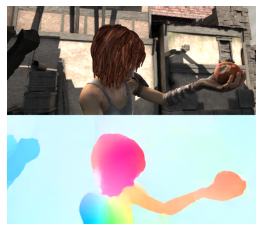

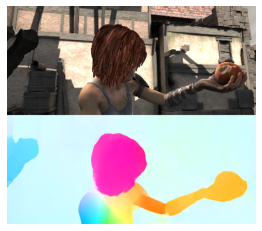

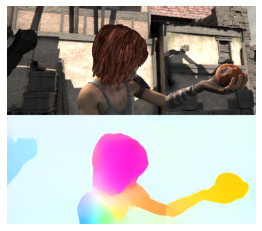

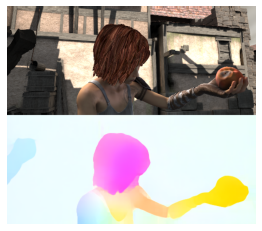

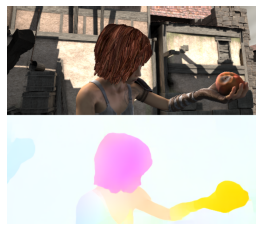

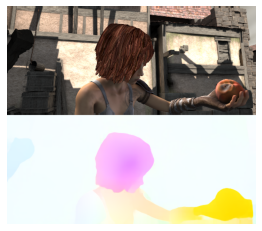

In [6]:
args = Namespace(alternate_corr=False, mixed_precision=False, model='models/raft-things.pth', path='halfSizeFrames', small=False)
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)
model.eval()

with torch.no_grad():
    images = glob.glob(os.path.join(args.path, '*.png')) + \
                 glob.glob(os.path.join(args.path, '*.jpg'))
        
    images = sorted(images)
    frame = 16
    for imfile1, imfile2 in zip(images[:-1], images[1:]):
        image1 = load_image(imfile1)
        image2 = load_image(imfile2)

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
        
        # save the optic flow file for each frame
        frame = frame + 1
        flow = padder.unpad(flow_up[0]).permute(1, 2, 0).cpu().numpy()
        output_file = os.path.join(args.path, 'frame%04d.flo' % (frame))
        frame_utils.writeFlow(output_file, flow)
        
        # visualize the optic flow for each frame
        viz(image1, flow_up)